In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 200 * BATCH_SIZE
TEST_SIZE = 4 * BATCH_SIZE
LOSS_EVERY = 1
EPOCH = 1
SPLIT = 'train'
LEARNING_RATE = .0005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp'
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 200 batches.
Test loader contains 4 batches.


torch.Size([64, 1, 224, 224])


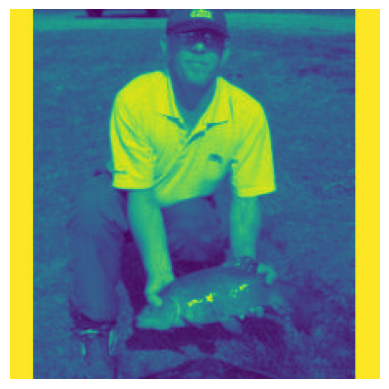

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()

        self.conv0 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=4,
            stride=4,
        )
        self.conv1 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,

            kernel_size=4,
            stride=4,
        )

        self.conv2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=5,
            padding=2, 
        )  
        self.conv3 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=3,
            padding=1, 
        )  
        self.conv4 = nn.ConvTranspose2d(
            in_channels=64, out_channels=32,
            kernel_size=3,
            padding=1, 
        )  
        self.conv5 = nn.ConvTranspose2d(
            in_channels=32, out_channels=16,
            kernel_size=1,
            padding=0, 
        )  
        self.conv6 = nn.ConvTranspose2d(
            in_channels=16, out_channels=1,
            kernel_size=1,
            padding=0, 
        )  

        self.relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv0(x)
        # x = self.relu(x)
        x = self.conv1(x)
        # x = self.relu(x)
        x = self.conv2(x)
        # x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        return x


# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(model))


Total parametrs:  11398657


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
num_epochs = 1
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(num_epochs):

    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)

        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY-1:
            avg_loss = running_loss/LOSS_EVERY
            print(avg_loss)
            losses.append(avg_loss)
            running_loss = 0.0

        constant_guess_loss = criterion(torch.full_like(target, 0), target)




0.6798751950263977


0.6843563914299011


0.6753331422805786


0.6543424129486084


0.6013880968093872


0.6974337100982666


0.6467595100402832


0.6490505337715149


0.6120442152023315


0.5915225744247437


0.6125258803367615


0.6328064203262329


0.6137459874153137


0.5822693109512329


0.5916649699211121


0.5947292447090149


0.5767017006874084


0.5990638732910156


0.5722452402114868


0.582184910774231


0.5781407952308655


0.5903374552726746


0.5992239713668823


0.6159869432449341


0.5994566679000854


0.5964073538780212


0.5824920535087585


0.5994184017181396


0.5923136472702026


0.5956231951713562


0.55595862865448


0.5620626211166382


0.5858729481697083


0.5933371186256409


0.5101727843284607


0.5339038372039795


0.5420981049537659


0.5710067749023438


0.6136133670806885


0.5739210247993469


0.6127457618713379


0.5959482789039612


0.6111305356025696


0.5961961150169373


0.6133730411529541


0.6104516386985779


0.6020896434783936


0.6026710271835327


0.6072196960449219


0.5959428548812866


0.6007606387138367


0.6003298163414001


0.5865533947944641


0.5994006991386414


0.6063269376754761


0.6082712411880493


0.5994995832443237


0.6120773553848267


0.607490599155426


0.6050455570220947


0.6073752045631409


0.575122594833374


0.583138644695282


0.5799761414527893


0.6065048575401306


0.5996683835983276


0.5959660410881042


0.5869883298873901


0.5917257070541382


0.6057375073432922


0.5921229124069214


0.5715671181678772


0.5835070610046387


0.5913553833961487


0.6088796854019165


0.5971224308013916


0.5895198583602905


0.5970746874809265


0.597445011138916


0.5802174806594849


0.5955249667167664


0.587471604347229


0.5809391736984253


0.5929670929908752


0.5809173583984375


0.5837599635124207


0.591454803943634


0.5787105560302734


0.5640553832054138


0.5531118512153625


0.5589556694030762


0.5777610540390015


0.5788396000862122


0.5698223114013672


0.5865329504013062


0.5883127450942993


0.5824821591377258


0.5756726861000061


0.565735936164856


0.5866410136222839


0.5891082882881165


0.575722873210907


0.5451541543006897


0.5373058319091797


0.561436653137207


0.5701437592506409


0.6022403240203857


0.5980780124664307


0.5926164984703064


0.5921915173530579


0.5108001828193665


0.5457523465156555


0.5445790886878967


0.5734411478042603


0.517439603805542


0.5614838004112244


0.5580826997756958


0.5458275675773621


0.5059618353843689


0.5736051797866821


0.541716992855072


0.5558915138244629


0.6251309514045715


0.6079508066177368


0.6132453083992004


0.6147350072860718


0.6154437065124512


0.6143220067024231


0.6300246715545654


0.6128783822059631


0.6157182455062866


0.6047660708427429


0.6247486472129822


0.6089026927947998


0.6125461459159851


0.6186214089393616


0.6203405857086182


0.6223478317260742


0.6178986430168152


0.6216658353805542


0.6192853450775146


0.5821694135665894


0.5828145742416382


0.5730833411216736


0.5529189705848694


0.5737478137016296


0.5660659670829773


0.576622486114502


0.5669815540313721


0.5613024234771729


0.5598396062850952


0.5617784857749939


0.5587315559387207


0.5595110654830933


0.5648054480552673


0.5619511604309082


0.5729165077209473


0.5603771209716797


0.5567378997802734


0.5653801560401917


0.5581099390983582


0.5606607794761658


0.5701303482055664


0.5692039132118225


0.5554288625717163


0.5698000192642212


0.5684128403663635


0.5700446963310242


0.5748205780982971


0.5765790939331055


0.5889634490013123


0.5776638984680176


0.5926109552383423


0.5808560252189636


0.5729037523269653


0.5703814029693604


0.5806772112846375


0.5759546756744385


0.5762709379196167


0.5561666488647461


0.5783460140228271


0.5821600556373596


0.5774992108345032


0.5809917449951172


0.5830073356628418


0.5693499445915222


0.5774106383323669


0.5740694403648376


0.5652271509170532


0.58676677942276


0.5814971923828125


0.5929206609725952


0.5707879066467285


0.5872485637664795


0.5745636820793152


0.5945889949798584


0.5867097973823547


0.5744982957839966


0.5717853307723999


0.5850870609283447


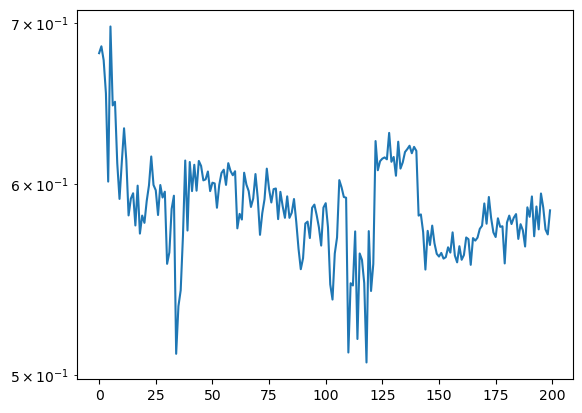

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:02,  1.49it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.51it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.58it/s]

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

Test Loss: 0.5734


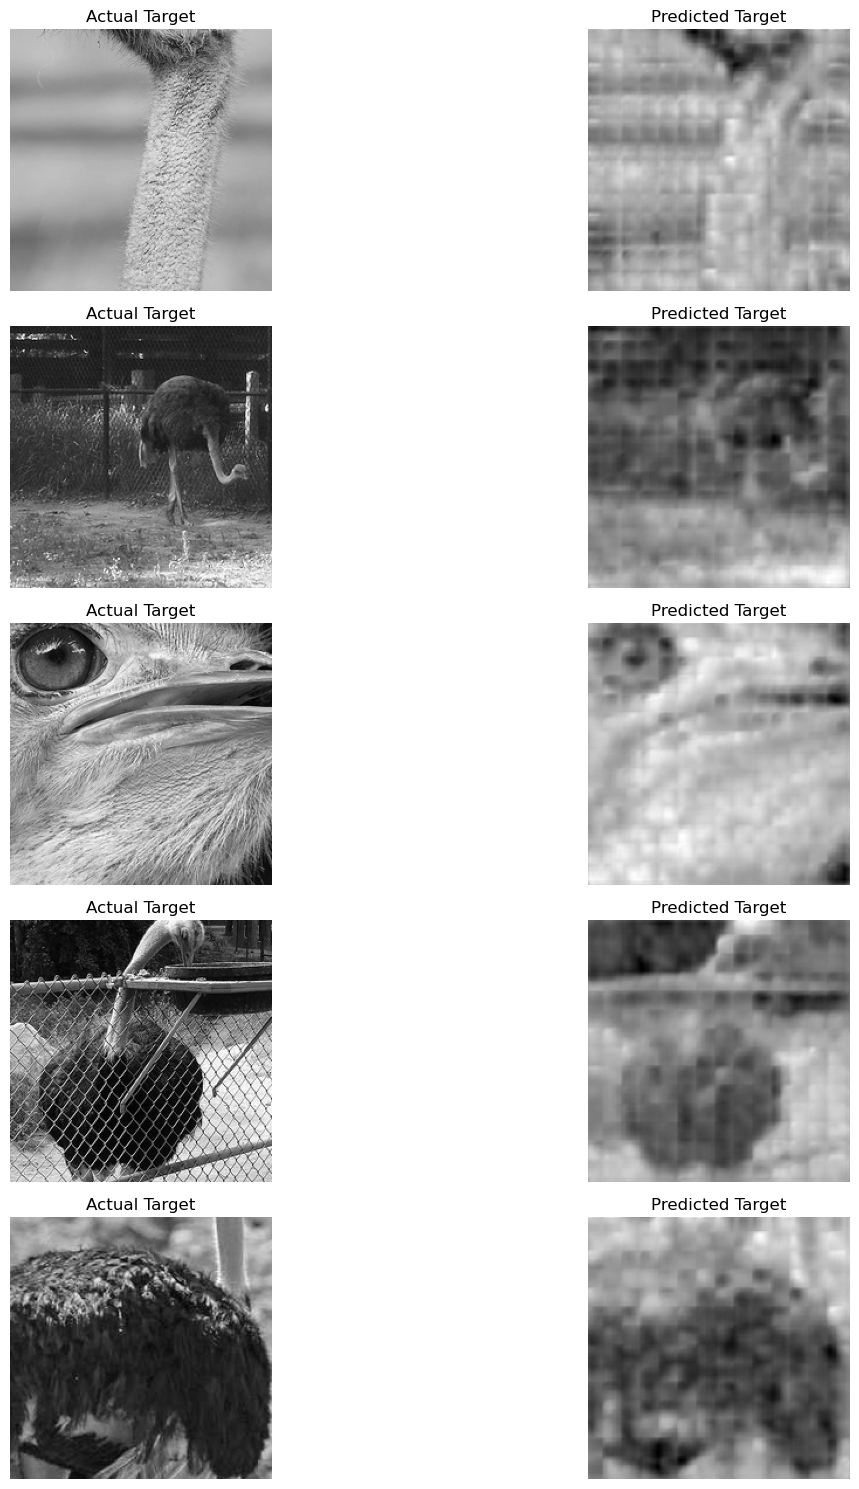

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-7.9889) tensor(5.8844)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))